We start by importing the OpenFst Python wrapper:

In [12]:
import openfst_python as fst

Then we create tables for our symbols

In [13]:
input_sym = fst.SymbolTable()
output_sym = fst.SymbolTable()

input_sym.add_symbol('<eps>') # by convention, <eps> always
                              # has symbol zero
input_sym.add_symbol('a')  # input symbols
input_sym.add_symbol('b')

output_sym.add_symbol('<eps>')  # output symbols
output_sym.add_symbol('d')
output_sym.add_symbol('c')

2

A **SymbolTable()** is simply a table associating symbols and indexes. We add symbols to the table with the method **add_symbol()**

Now that we've got our symbol tables, we will build the FST itself:

In [14]:
f = fst.Fst()

f.set_input_symbols(input_sym)
f.set_output_symbols(output_sym)

Our FST transduces the input to the outputs, so we set the symbol tables as such. Now, we want to add a number of states:

In [15]:
s0 = f.add_state()
s1 = f.add_state()
s2 = f.add_state()
s3 = f.add_state()

The output of the **add_state()** method is just the index assigned to the state, but it can be useful to assign that index to a variable to give it a more meaningful label.

To create arcs between states, we do:

In [16]:
a = input_sym.find('a')
b = input_sym.find('b')
c = output_sym.find('c')
d = output_sym.find('d')

f.add_arc(s0, fst.Arc(a, c, None, s1))
f.add_arc(s0, fst.Arc(b, d, None, s2))
f.add_arc(s1, fst.Arc(a, c, None, s3))
f.add_arc(s2, fst.Arc(b, d, None, s3))

The syntax for the method **add_arc** is:

**add_arc(*source state*, *arc to add*)**

while the syntax for initializing a class **Arc()** is:

**Arc(*input symbol index*, *output symbol index*, *weight*, *destination state*)**

We use the **find()** method of the symbol tables to get the index of a certain label.

Now we just add start and end states:

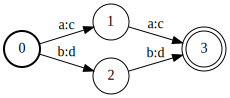

In [18]:
f.set_start(s0)
f.set_final(s3)

And voila, our first FST, shown in the example above, is done!

# Exercises

In [19]:
def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    return lex

In [20]:
lex = parse_lexicon('lexicon.txt')
lex

{'a': ['ey'],
 'cat': ['k', 'ae', 't'],
 'of': ['ah', 'v'],
 'peck': ['p', 'eh', 'k'],
 'peppers': ['p', 'eh', 'p', 'er', 'z'],
 'peter': ['p', 'iy', 't', 'er'],
 'picked': ['p', 'ih', 'k', 't'],
 'pickled': ['p', 'ih', 'k', 'ah', 'l', 'd'],
 'piper': ['p', 'ay', 'p', 'er'],
 'the': ['dh', 'iy'],
 "where's": ['w', 'eh', 'r', 'z']}

1. Write a function that generates symbol tables from a lexicon, using the provided phonetic dictionary in **lexicon.txt** and the helper function *parse_lexicon* in cells above. Use p_1, p_2, ..., eh_1, ... to denote the phone states. 

In [21]:
def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
        
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # add empty <eps> symbol to all tables
    state_table.add_symbol('<eps>')
    phone_table.add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    
    for word, phones  in lexicon.items():
        
        word_table.add_symbol(word)
        
        for p in phones: # for each phone
            
            phone_table.add_symbol(p)
            for i in range(1,n+1): # for each state 1 to n
                state_table.add_symbol('{}_{}'.format(p, i))
            
    return word_table, phone_table, state_table

In [22]:
word_table, phone_table, state_table = generate_symbol_tables(lex)

2. Create functions generating WFSTs representing the following HMMs:

    1. A 3-state left-to-right phone HMM with self-loops
    2. A parallel-path left-to-right model (shown on Slide 10 of Lecture 4)
    3. An ergodic HMM with $n$ states (you will need to think about how to handle final states)

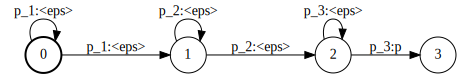

In [23]:
def generate_phone_wfst(f, start_state, phone, n):
    """
    Generate a WFST representing an n-state left-to-right phone HMM.
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        phone (str): the phone label 
        n (int): number of states of the HMM
        
    Returns:
        the final state of the FST
    """
    
    current_state = start_state
    
    for i in range(1, n+1):
        
        in_label = state_table.find('{}_{}'.format(phone, i))
        
        # self-loop back to current state
        f.add_arc(current_state, fst.Arc(in_label, 0, None, current_state))
        
        # transition to next state
        
        # we want to output the phone label on the final state
        # note: if outputting words instead this code should be modified
        if i == n:
            out_label = phone_table.find(phone)
        else:
            out_label = 0   # output empty <eps> label
            
        next_state = f.add_state()
        f.add_arc(current_state, fst.Arc(in_label, out_label, None, next_state))    
       
        current_state = next_state
    return current_state

f = fst.Fst()
start = f.add_state()
f.set_start(start)

last_state = generate_phone_wfst(f, start, 'p', 3)

f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)

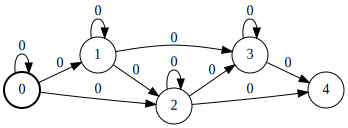

In [25]:
def generate_parallel_path_wfst(f, start_state, n):
    """
    Generate a WFST representing an n-state parallel-path left-to-right HMM
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        n (int): number of states of the HMM
        
    Returns:
        the final state of the FST
    """
    
    current_state = start_state
    next_state = f.add_state()
    for i in range(n):

        # self-loop back to current state
        f.add_arc(current_state, fst.Arc(0, 0, None, current_state))
        f.add_arc(current_state, fst.Arc(0, 0, None, next_state))
        if i != n-1:
            next_next_state = f.add_state()
            f.add_arc(current_state, fst.Arc(0, 0, None, next_next_state))
        current_state = next_state
        next_state = next_next_state

    return current_state


f = fst.Fst()
start = f.add_state()
f.set_start(start)

last_state = generate_parallel_path_wfst(f, start, 4)
f

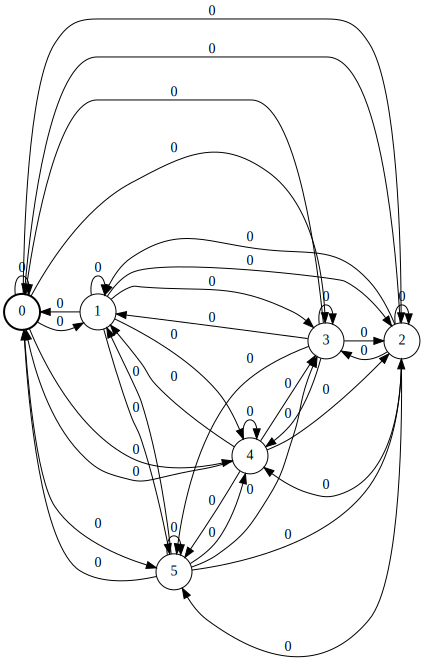

In [13]:
def generate_ergodic_wfst(f, start_state, n):
    """
    Generate a WFST representing an n-state ergodic HMM
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        n (int): number of states of the HMM excluding start and end
        
    Returns:
        the final state of the FST
    """    
    
    current_state = start_state
    
    for i in range(n):
        f.add_state()
        
    for i in range(n+1): # +1 is start state
        for j in range(n+1):
            f.add_arc(i, fst.Arc(0, 0, None, j))

    return current_state


f = fst.Fst()
start = f.add_state()
f.set_start(start)

last_state = generate_ergodic_wfst(f, start, 5)
f

3. Write a function to generate an HMM for any word in the lexicon using $n$ states per phone by concatenating $n$-state phone HMMs. Make use of your *generate_phone_wfst()* function. 

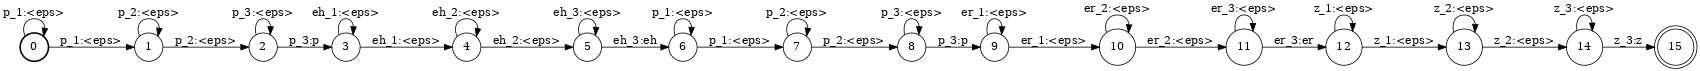

In [14]:
def generate_word_wfst(f, start_state, word, n):
    """ Generate a WFST for any word in the lexicon, composed of n-state phone WFSTs.
        This will currently output phone labels.
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        word (str): the word to generate
        n (int): states per phone HMM
        
    Returns:
        the constructed WFST
    
    """

    current_state = start_state
    
    # iterate over all the phones in the word
    for phone in lex[word]:   # will raise an exception if word is not in the lexicon
        # your code here
        
        current_state = generate_phone_wfst(f, current_state, phone, n)
    
        # note: new current_state is now set to the final state of the previous phone WFST
        
    f.set_final(current_state)
    
    return f

f = fst.Fst()
start = f.add_state()
f.set_start(start)

generate_word_wfst(f, start, 'peppers', 3)
f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)

from subprocess import check_call
from IPython.display import Image
f.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
Image(filename='tmp.png')

4. Generate an HMM that can recognise:

    1. any phone contained in the lexicon
    2. any sequence of phones contained in the lexicon
    
Think of the difference between the first and the second HMM. Again, previous functions should help in the task. 

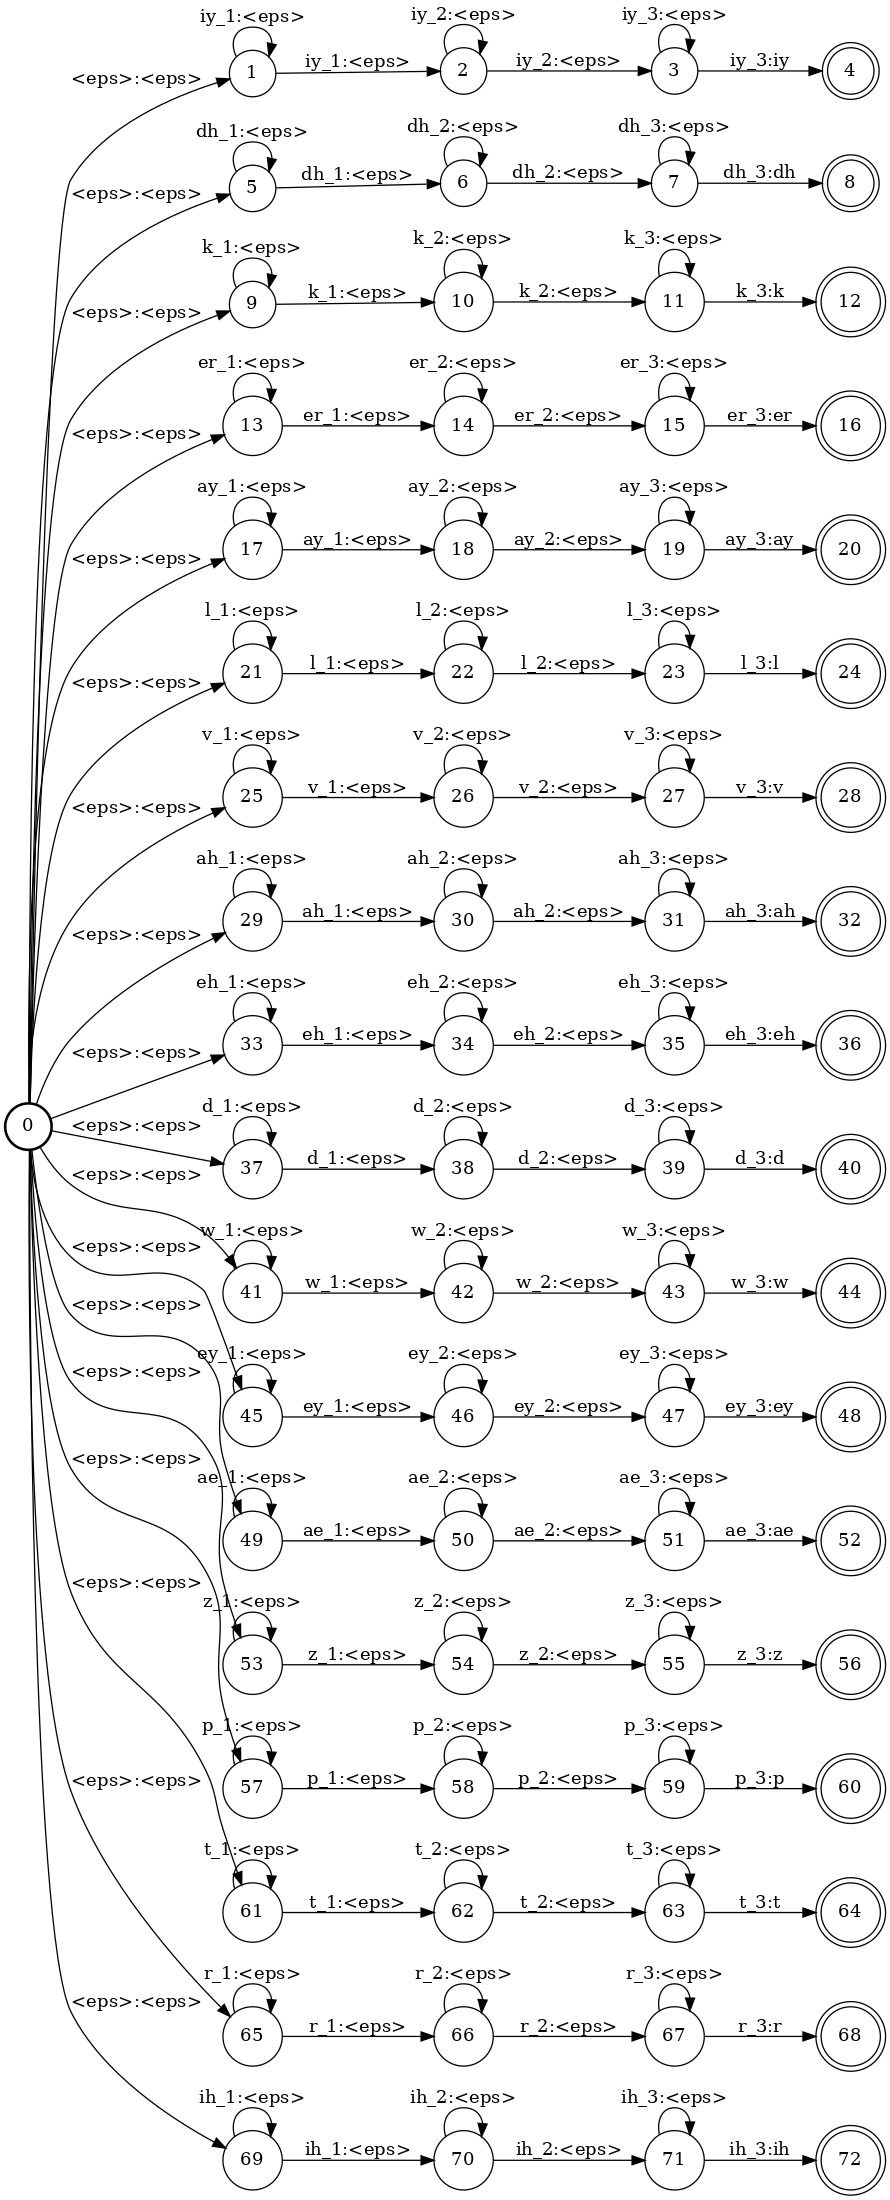

In [15]:
def generate_phone_recognition_wfst(n):
    """ generate a HMM to recognise any single phone in the lexicon
    
    Args:
        n (int): states per phone HMM

    Returns:
        the constructed WFST
    
    """
    
    f = fst.Fst()
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    
    # get a list of all the phones in the lexicon
    # there are lots of way to do this.  Here, we use the set() object

    # will contain all unique phones in the lexicon
    phone_set = set()
    
    for pronunciation in lex.values():
        phone_set = phone_set.union(pronunciation)
        
    for phone in phone_set:
        
        # we need to add an empty arc from the start state to where the actual phone HMM
        # will begin.  If you can't see why this is needed, try without it!
        current_state = f.add_state()
        f.add_arc(start_state, fst.Arc(0, 0, None, current_state))
    
        end_state = generate_phone_wfst(f, current_state, phone, n)
    
        f.set_final(end_state)

    return f

f = generate_phone_recognition_wfst(3)
f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)

f.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
Image(filename='tmp.png')

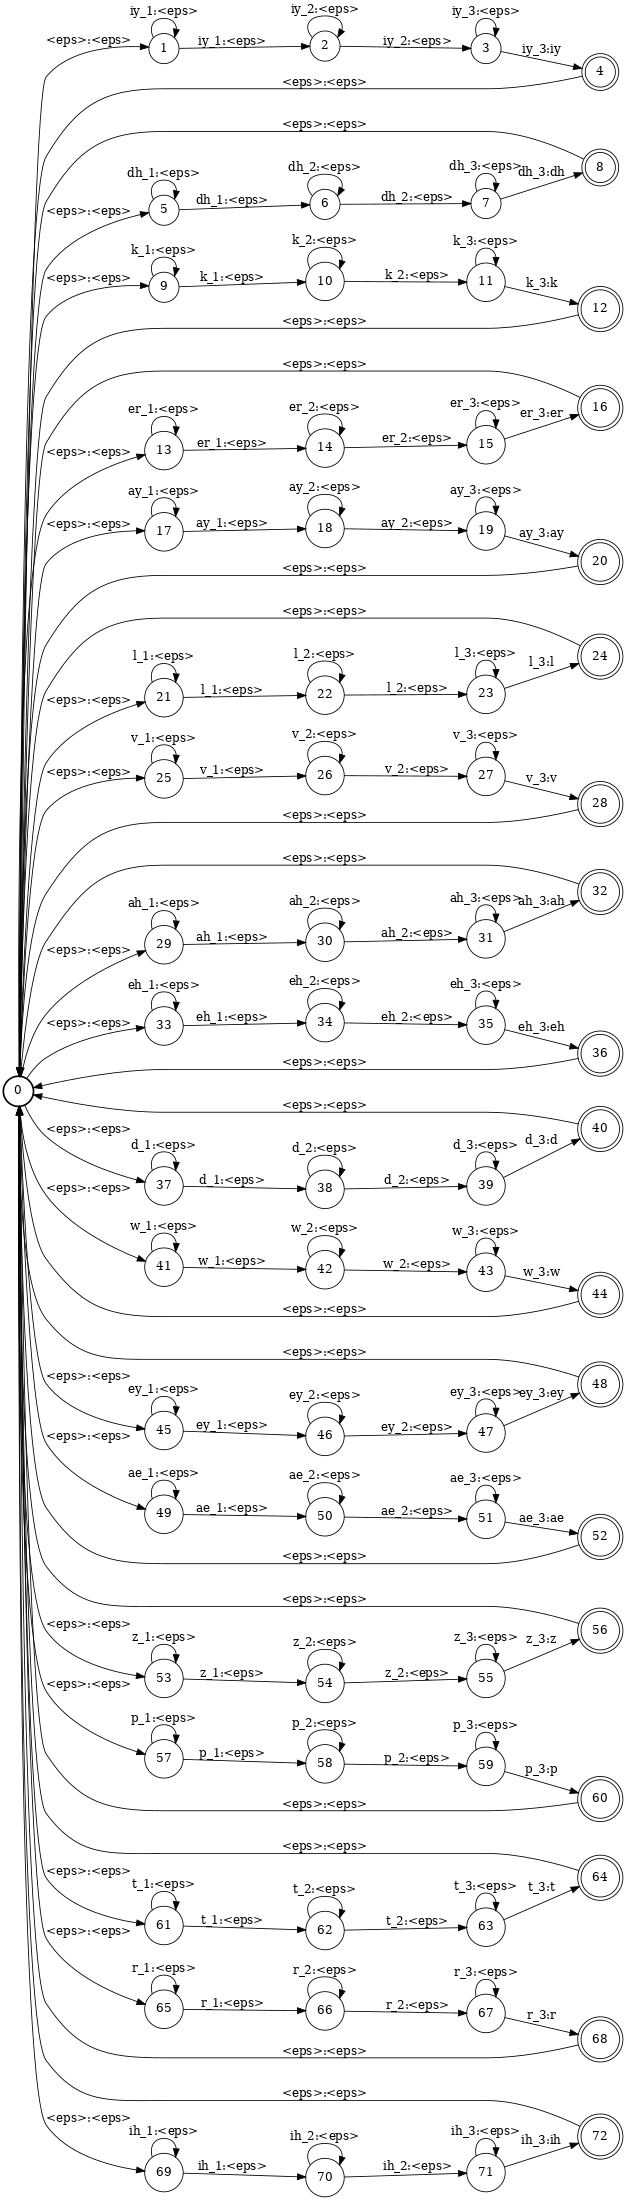

In [16]:
def generate_phone_sequence_recognition_wfst(n):
    """ generate a HMM to recognise any single phone sequence in the lexicon
    
    Args:
        n (int): states per phone HMM

    Returns:
        the constructed WFST
    
    """
    
    f = fst.Fst()
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    
    phone_set = set()
    
    for pronunciation in lex.values():
        phone_set = phone_set.union(pronunciation)
        
    for phone in phone_set:
        current_state = f.add_state()
        f.add_arc(start_state, fst.Arc(0, 0, None, current_state))
    
        end_state = generate_phone_wfst(f, current_state, phone, n)
        
        f.add_arc(end_state, fst.Arc(0,0, None, start_state))
        f.set_final(end_state)

    return f

f = generate_phone_sequence_recognition_wfst(3)
f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)

f.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
Image(filename='tmp.png')

5. You have decided that the best way to start teaching a friend English is to have them learn the notorious tongue-twister *peter piper picked a peck of pickled peppers*.  Write a function that creates an HMM that can recognize any sequence of these words.

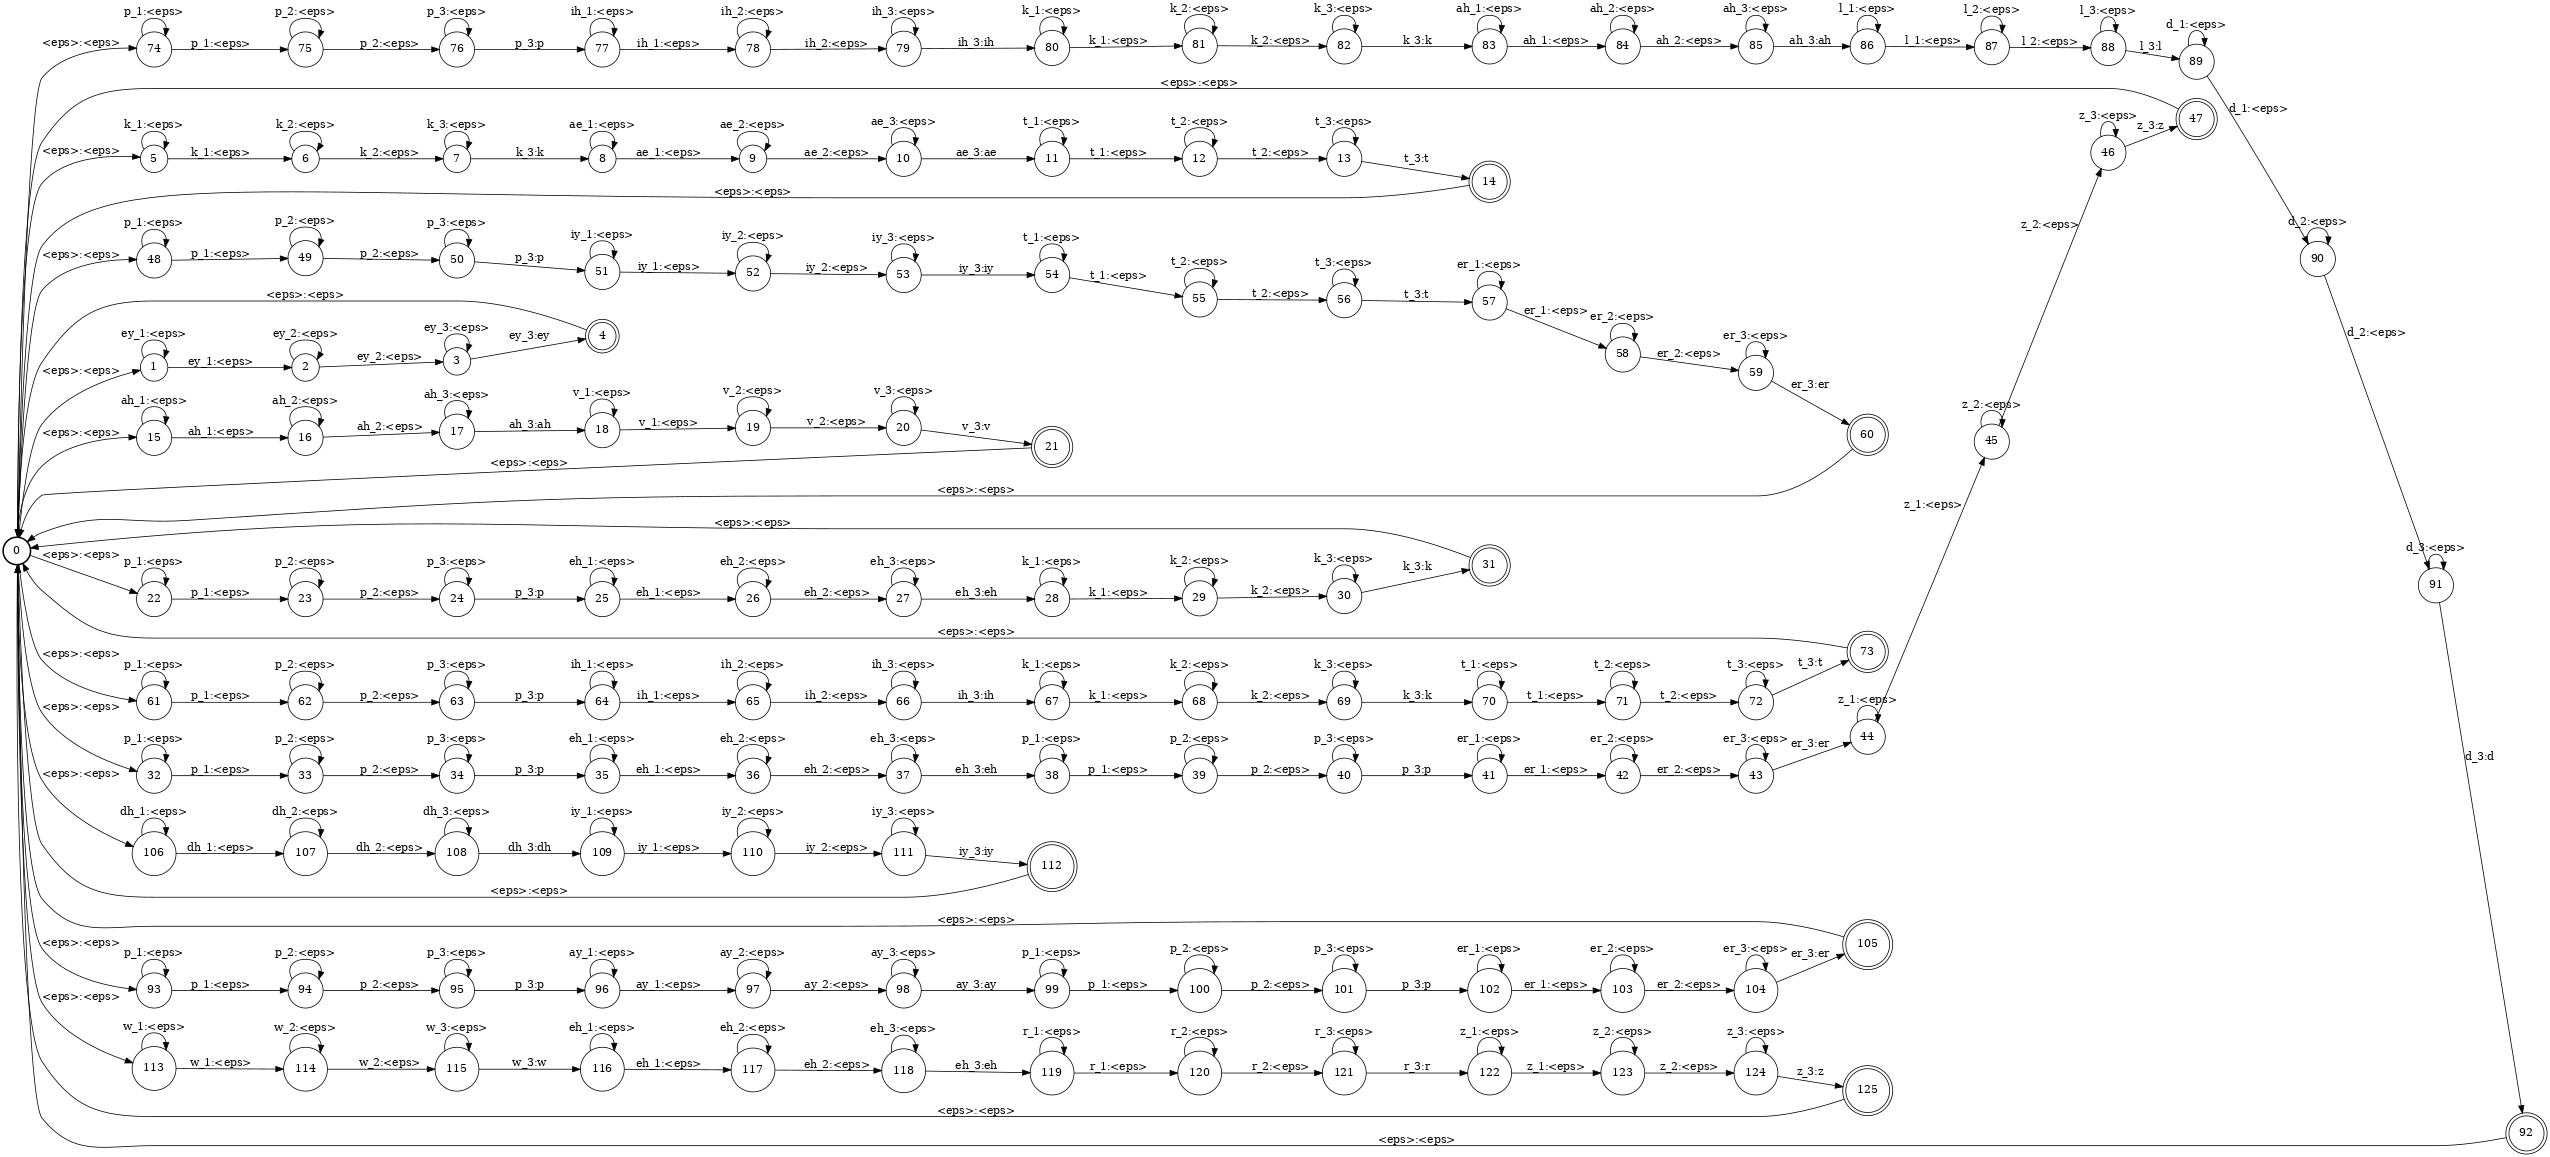

In [17]:
def generate_word_sequence_recognition_wfst(n):
    """ generate a HMM to recognise any single word sequence for words in the lexicon
    
    Args:
        n (int): states per phone HMM

    Returns:
        the constructed WFST
    
    """
    
    f = fst.Fst()
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    
    for word, phones in lex.items():
        current_state = f.add_state()
        f.add_arc(start_state, fst.Arc(0, 0, None, current_state))
        
        for phone in phones: 
            current_state = generate_phone_wfst(f, current_state, phone, n)
        # note: new current_state is now set to the final state of the previous phone WFST
        
        f.set_final(current_state)
        f.add_arc(current_state, fst.Arc(0, 0, None, start_state))
        
    return f

f = generate_word_sequence_recognition_wfst(3)
f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)

f.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=300','tmp.dot','-o','tmp.png'])
Image(filename='tmp.png')

# If you have more time

Probabilities in WFSTs are traditionally expressed in negative log format, that is, the weight $w$ on an arc transitioning between states $i$ and $j$ is given by $w=-\log a_{ij}$, where $a_{ij}$ is the HMM transition probability.

6. Add weights to your WFSTs corresponding to transition probabilities.  Assume that the probability of a self-loop is $0.1$, and that when transitioning *between* separate phones or words, the probabilities are uniform over all transitions.